In [1]:
import flax
import flax.nnx as nnx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax_autovmap import auto_vmap
from functools import partial
from tqdm import tqdm

import optax

import lfx

from IPython import display  # for displaying ESS

rngs = nnx.Rngs(0)

In [2]:
@partial(jax.jit, static_argnums=(1, 2))
def sample_swiss_roll(rng, n_samples=1000, noise=0.1):
    t = jax.random.uniform(rng, (n_samples,), minval=0, maxval=4 * np.pi)
    noise_values = jax.random.normal(rng, (n_samples, 2)) * noise

    x = t * jnp.cos(t)
    y = t * jnp.sin(t)
    points = jnp.stack([x, y], axis=1) + noise_values

    return points

In [3]:
cluster_count = 100

sampler = lfx.gmm.DiagonalGMM(
    2 * np.random.normal(size=(cluster_count, 2)),
    (cluster_count, 2),
    (cluster_count,),
    rngs=rngs,
)

In [4]:
optimizer = nnx.Optimizer(
    sampler,
    optax.adam(1e-2),
)

In [5]:
def loss_fn(sampler, samples):
    log_prob = sampler.log_prob(samples)
    return -jnp.mean(log_prob)


@nnx.jit
def update_step(optimizer, samples):
    loss, grads = nnx.value_and_grad(loss_fn)(optimizer.model, samples)
    optimizer.update(grads)
    return loss

In [6]:
steps = 1000
log_every = 100

losses = np.full(steps, np.nan)


@nnx.jit
def _draw(sampler):
    return sampler.sample((1000,), jax.random.key(42))

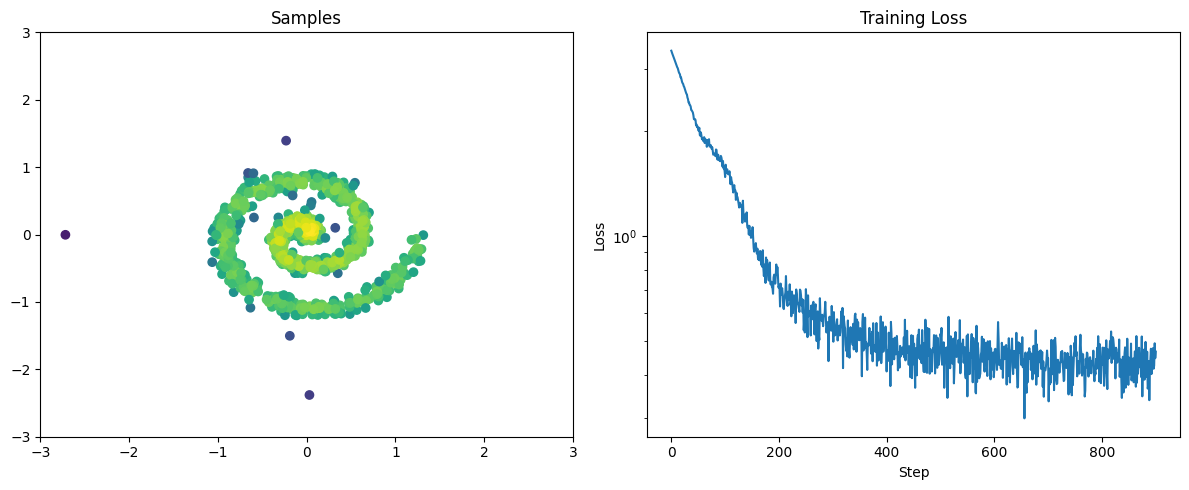

100%|██████████| 1000/1000 [00:02<00:00, 337.89it/s]


In [7]:
for step in tqdm(range(steps)):
    samples = sample_swiss_roll(n_samples=512, noise=0.5, rng=rngs()) / 10
    losses[step] = update_step(optimizer, samples)

    if step % log_every == 0:
        display.clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Plot samples
        x, lp = _draw(sampler)
        ax1.scatter(*x.T, c=lp)
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_title("Samples")

        # Plot loss
        valid_losses = losses[:step+1]
        ax2.plot(valid_losses)
        ax2.set_xlabel("Step")
        ax2.set_ylabel("Loss")
        ax2.set_title("Training Loss")
        ax2.set_yscale('log')

        plt.tight_layout()
        plt.show()
        plt.close('all')
